In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/tiktok/tiktok_dataset.csv', index_col=['#'])
df.head()

claim_status    video_id  video_duration_sec  \
#                                                
1        claim  7017666017                  59   
2        claim  4014381136                  32   
3        claim  9859838091                  31   
4        claim  1866847991                  25   
5        claim  7105231098                  19   

                            video_transcription_text verified_status  \
#                                                                      
1  someone shared with me that drone deliveries a...    not verified   
2  someone shared with me that there are more mic...    not verified   
3  someone shared with me that american industria...    not verified   
4  someone shared with me that the metro of st. p...    not verified   
5  someone shared with me that the number of busi...    not verified   

  author_ban_status  video_view_count  video_like_count  video_share_count  \
#                                                                            
1      under review          343296.0           19425.0              241.0   
2            active          140877.0           77355.0            19034.0   
3            active          902185.0           97690.0             2858.0   
4            active          437506.0          239954.0            34812.0   
5            active           56167.0           34987.0             4110.0   

   video_download_count  video_comment_count  
#                                             
1                   1.0                  0.0  
2                1161.0                684.0  
3                 833.0                329.0  
4                1234.0                584.0  
5                 547.0                152.0

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19382 entries, 1 to 19382
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   claim_status              19084 non-null  object 
 1   video_id                  19382 non-null  int64  
 2   video_duration_sec        19382 non-null  int64  
 3   video_transcription_text  19084 non-null  object 
 4   verified_status           19382 non-null  object 
 5   author_ban_status         19382 non-null  object 
 6   video_view_count          19084 non-null  float64
 7   video_like_count          19084 non-null  float64
 8   video_share_count         19084 non-null  float64
 9   video_download_count      19084 non-null  float64
 10  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 1.8+ MB


In [3]:
df.nunique()

claim_status                    2
video_id                    19382
video_duration_sec             56
video_transcription_text    19012
verified_status                 2
author_ban_status               3
video_view_count            15632
video_like_count            12224
video_share_count            9231
video_download_count         4336
video_comment_count          2424
dtype: int64

In [4]:
from plotly.express import bar
for column in ['claim_status', 'verified_status', 'author_ban_status']:
    bar(data_frame=df[column].value_counts().to_frame().reset_index(), x=column, y='count').show()

In [5]:
from plotly.express import histogram
for column in df.columns:
    if 'count' in column:
        histogram(data_frame=df, x=column, log_y=True, color='claim_status').show()
        histogram(data_frame=df, x=column, log_y=True, color='author_ban_status').show()
    elif 'duration' in column:
        histogram(data_frame=df, x=column, log_y=False, color='claim_status').show()
        histogram(data_frame=df, x=column, log_y=False, color='author_ban_status').show()

The durations are essentially uniformly distributed, while the various counts are mostly zero. And we see the trends that we expect to see, very broadly speaking, in social media data: views > likes > comments; this is the first time I've seen download data, but I guess it's not surprising that shares > downloads > comments. Generally we expect that the more effort something takes the fewer people will do it.

The fact that the status = opinion videos are all concentrated near the zero engagement point suggests they are being throttled somehow.

In [6]:
from plotly.express import imshow
imshow(img=df[[column for column in df.columns if 'count' in column or 'duration' in column]].corr())

These engagement correlations are pretty high; I think the lowest is .55, which surprises me even if it isn't surprising.

In [7]:
from plotly.express import scatter
for color in ['verified_status', 'author_ban_status']:
    scatter(data_frame=df.sample(n=2500, random_state=2023), x='video_view_count', y='video_like_count', size='video_duration_sec',
            opacity=0.2, hover_name='video_id', color=color).show()

This is consistent with what we see on other social media platforms, that most of the content, and in particular most of the high-engagement content is made by unverified users; this may be why the platforms don't make more of an effort to eliminate anonymous users.

In [8]:
scatter(data_frame=df.sample(n=2500, random_state=2023), x='video_share_count', y='video_download_count', size='video_duration_sec',
        opacity=0.2, hover_name='video_id', color='verified_status', log_x=True, log_y=True, trendline='ols', trendline_scope='overall')

In [9]:
scatter(data_frame=df.sample(n=2500, random_state=2023), x='video_share_count', y='video_comment_count', size='video_duration_sec',
        opacity=0.2, hover_name='video_id', color='author_ban_status', log_x=True, log_y=True, trendline='ols', trendline_scope='overall')

Other engagements are typically dependent on views, so we see a triangular covariance; not so with the other engagement metrics.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



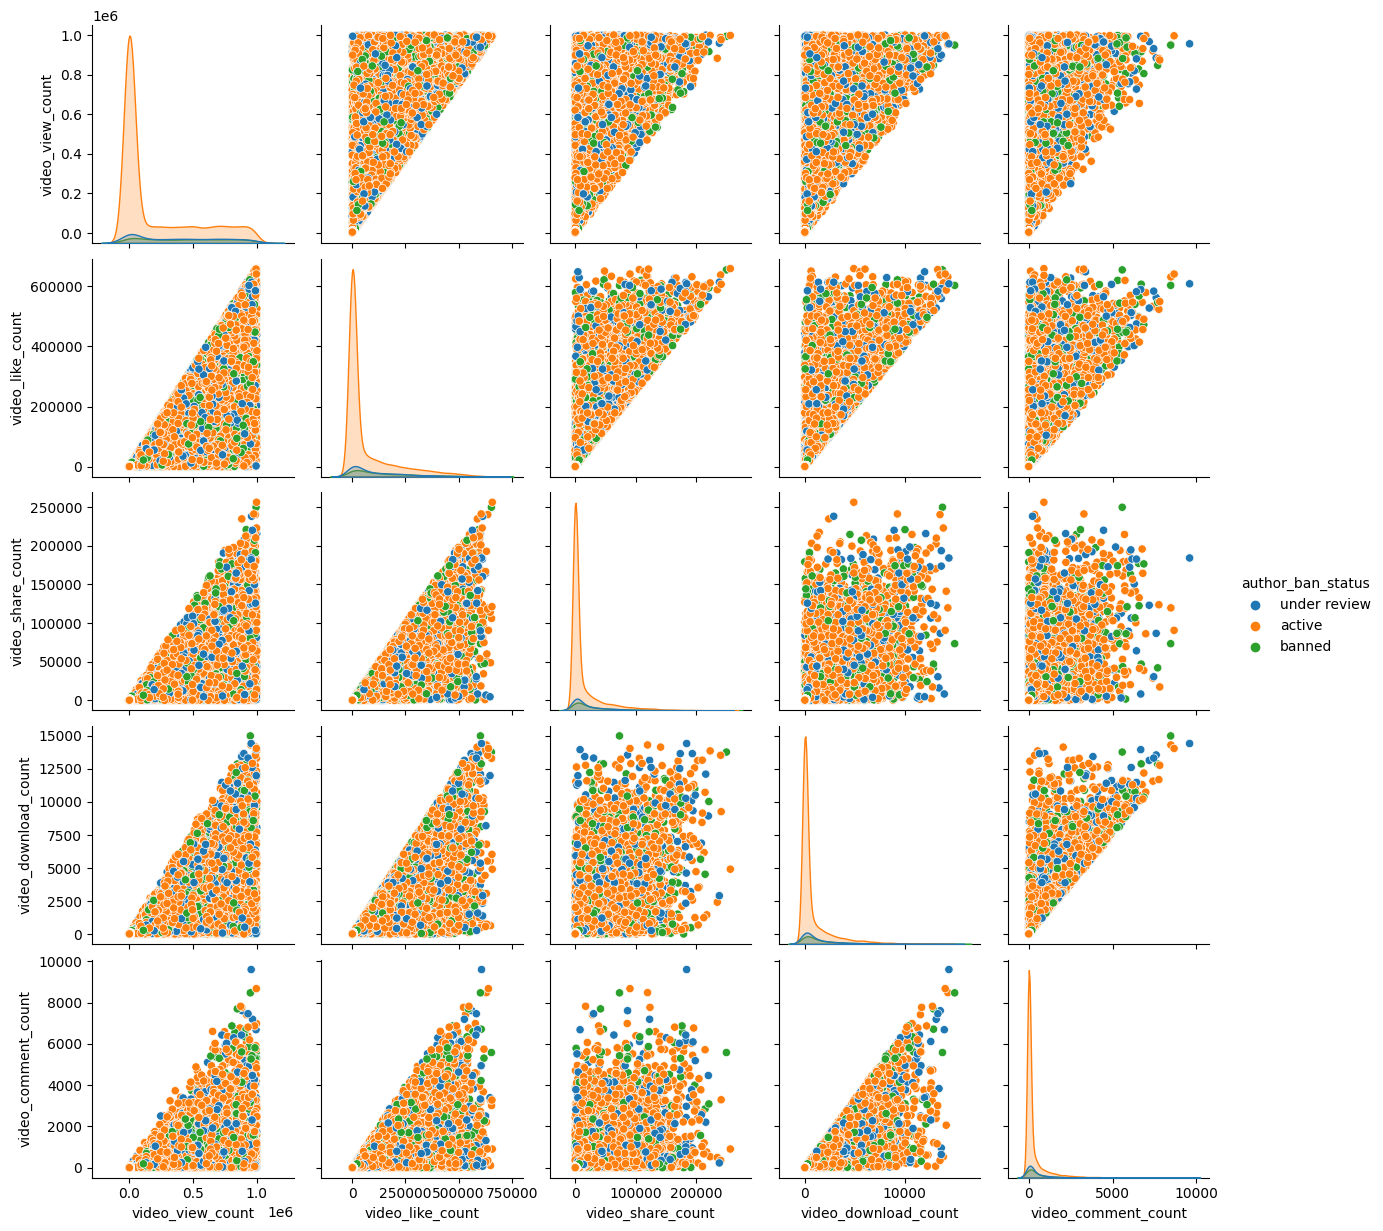

In [10]:
from seaborn import pairplot
pairplot(data=df[['author_ban_status'] + [column for column in df.columns if 'count' in column]], hue='author_ban_status', )

This doesn't tell us much; let's remove the active users.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



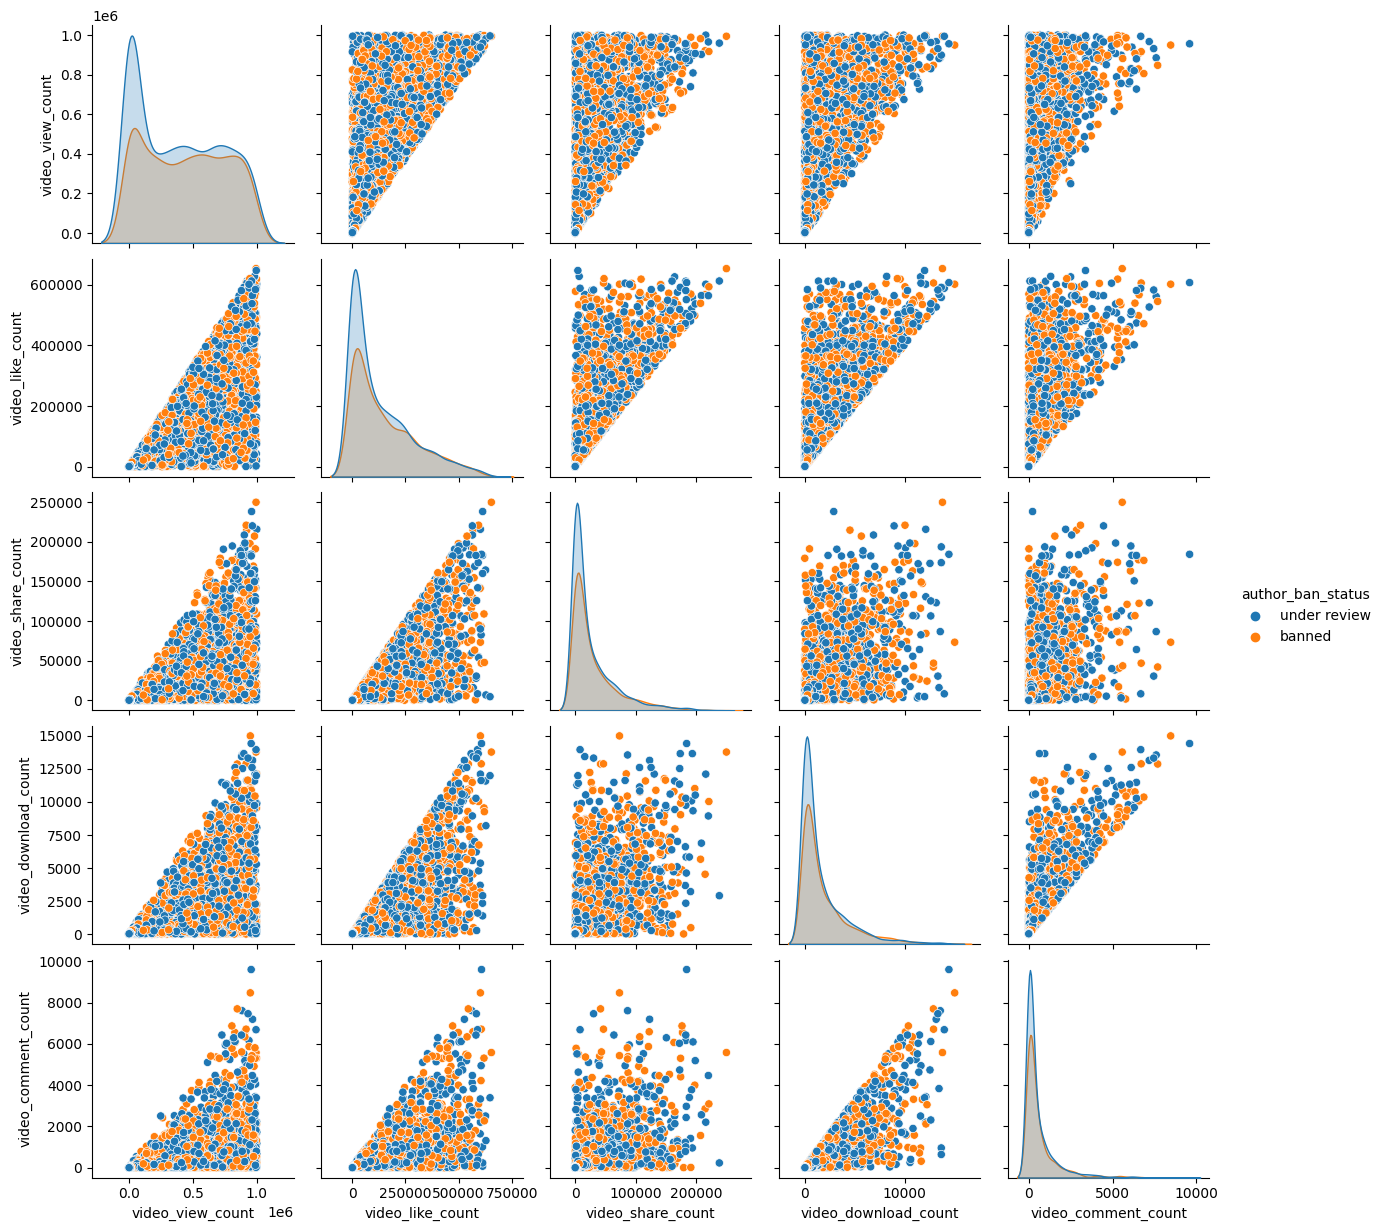

In [11]:
pairplot(data=df[df['author_ban_status'] != 'active'][['author_ban_status'] + [column for column in df.columns if 'count' in column]], hue='author_ban_status', )

(-0.5, 1199.5, 1199.5, -0.5)

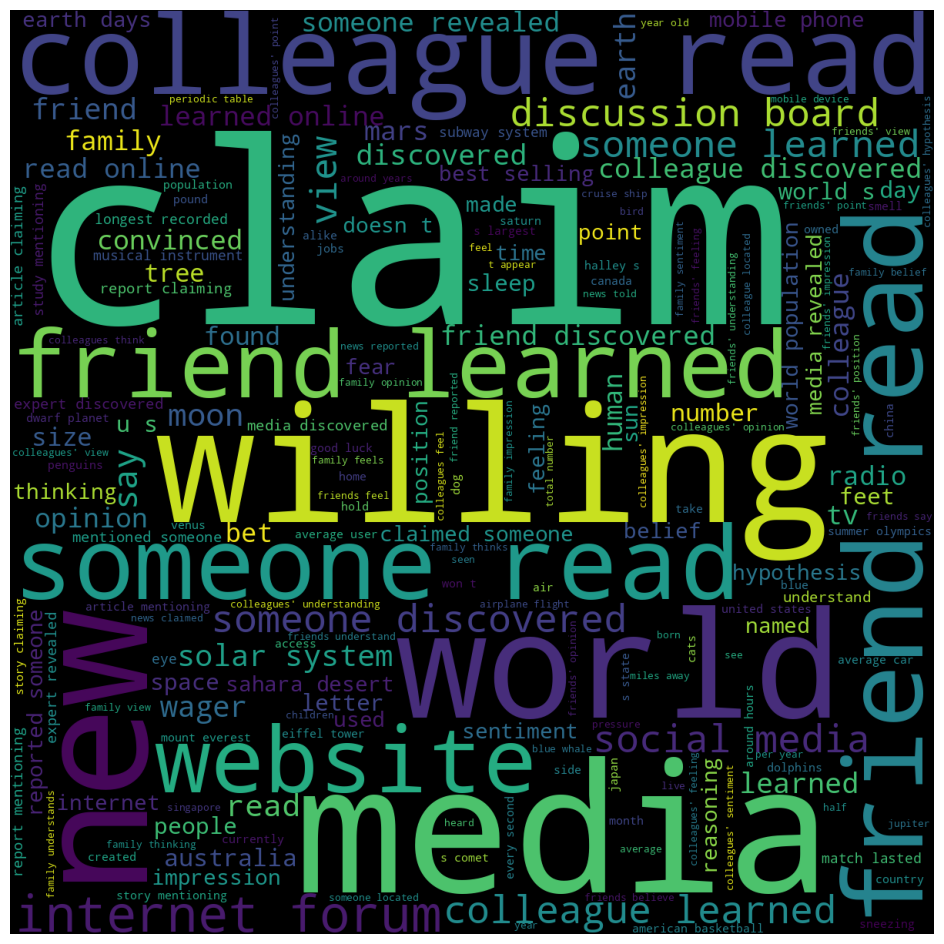

In [12]:
from matplotlib.pyplot import subplots
from matplotlib.pyplot import axis
from matplotlib.pyplot import imshow
from wordcloud import WordCloud
subplots(figsize=(12, 12))
imshow(X=WordCloud(random_state=2023, height=1200, width=1200, ).generate(text=' '.join(df['video_transcription_text'].dropna().values), ))
axis('off')

Goodness there's a lot of reading and learning happening here.

In [13]:
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import strip_tags
CUSTOM_FILTERS = [lambda x: x.lower(), 
                  remove_stopwords, 
                  strip_multiple_whitespaces, 
                  strip_numeric,
                  strip_punctuation,
                  strip_short,
                  strip_tags, 
                 ]
texts = [preprocess_string(s=document, filters=CUSTOM_FILTERS) for document in df['video_transcription_text'].dropna().values]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
print(dictionary)

Dictionary<1090 unique tokens: ['common', 'deliveries', 'drone', 'happening', 'shared']...>


In [14]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

for num_topics in range(140, 150):
    print(num_topics, 
        CoherenceModel(model=LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=2023), corpus=corpus,
                       coherence='u_mass').get_coherence())

140 -8.938250250669967
141 -8.718249812802759
142 -9.016582535737903
143 -8.520462341546724
144 -8.741987840327464
145 -8.9291041968823
146 -8.426953751205916
147 -8.878350128691531
148 -8.815709419628597
149 -9.012421151422682


In [15]:
NUM_TOPICS = 146
lda_model = LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary, random_state=2023)
print('coherence: {:5.2f}'.format(CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass').get_coherence()))

coherence: -8.43
